# Google Leak

## BGP data feature per ASN

In [ ]:
import pybgpstream
import editdistance
import pandas as pd
from datetime import datetime, timedelta

# Initialize the BGPStream
stream = pybgpstream.BGPStream(
    from_time="2018-04-25 08:30:00",
    until_time="2018-04-25 12:00:00",
    record_type="updates",
    collectors=["rrc00"]
)

# Function to initialize the feature dictionary
def init_features():
    return {
        "timestamp": None,
        "num_announcements" : 0, # Number of announcements
        "num_withdrawals" : 0, # Number of withdrawals:
        "num_implicit_withdrawals" : 0,  
        "num_duplicate_announcements" : 0,
        "num_duplicate_withdrawals" : 0,
        "num_announced_prefixes" : 0, # Number of announced prefixes
        "num_withdrawn_prefixes" : 0, # Number of withdrawn prefixes
        "max_announcements_per_prefix" : 0, # Max. announcements per prefix
        "avg_announcements_per_prefix" : 0, # Avg. announcements per prefix
        "num_new_announcements" : 0, # Not stored in RIB
        "num_new_announcements_after_withdrawal" : 0, 
        "max_path_length" : 0,
        "avg_path_length" : 0,
        "max_edit_distance" : 0,
        "avg_edit_distance" : 0,
        "avg_interarrival_time" : 0,
    }

# Initialize DataFrame to store the aggregated features
columns = list(init_features().keys())
df_features = pd.DataFrame(columns=columns)

# Initialize variables
routes = {}
A_per_prefix = {}
W_per_prefix = {}
path_len = []
inter_time = []
editDist = []

prevTime = 0
index = 0
# target_asn = "15169"
# target_asn = "37282"
target_asn = "4809"

# Initialize feature set for the first 5-minute window
current_window_start = datetime.strptime("2018-04-25 08:30:00", "%Y-%m-%d %H:%M:%S")
current_features = init_features()
current_features["timestamp"] = current_window_start

# Process BGP records
for rec in stream.records():
    for elem in rec:
        update = elem.fields
        elem_time = datetime.utcfromtimestamp(elem.time)
        
        if elem_time >= current_window_start + timedelta(minutes=5):
            # Final aggregation for the current window
            current_features["num_announced_prefixes"] = len(A_per_prefix)
            current_features["num_withdrawn_prefixes"] = len(W_per_prefix)
            A_per_prefix_values = A_per_prefix.values()
            if len(A_per_prefix_values) > 1:
                current_features["max_announcements_per_prefix"] = max(A_per_prefix_values)
                current_features["avg_announcements_per_prefix"] = round(sum(A_per_prefix_values) / len(A_per_prefix_values))

            if len(path_len) > 1:
                current_features["max_path_length"] = max(path_len)
                current_features["avg_path_length"] = round(sum(path_len) / len(path_len))

            if len(inter_time) > 1:
                current_features["avg_interarrival_time"] = round(sum(inter_time) * 1000 / len(inter_time))

            if len(editDist) > 1:
                current_features["max_edit_distance"] = max(editDist)
                current_features["avg_edit_distance"] = round(sum(editDist) / len(editDist))
            
            # Append the features to the DataFrame
            df_features = pd.concat([df_features, pd.DataFrame([current_features])], ignore_index=True)

            # Reset variables for the new window
            current_window_start += timedelta(minutes=5)
            current_features = init_features()
            current_features["timestamp"] = current_window_start
            routes = {}
            A_per_prefix = {}
            W_per_prefix = {}
            path_len = []
            inter_time = []
            editDist = []
            prevTime = 0
            index = 0

        if "prefix" not in update or "as-path" not in update:
            continue
        
        as_path = update['as-path'].split()
        origin_as = as_path[-1]
        if origin_as != target_asn:
            continue
        
        prefix = update["prefix"]
        peer_asn = update.get("peer_asn", "unknown")
        collector = rec.collector

        if prefix not in routes:
            routes[prefix] = {}
        if collector not in routes[prefix]:
            routes[prefix][collector] = {}

        if elem.type == 'A':
            current_features["num_announcements"] += 1

            path_len.append(len(as_path))

            if prefix not in A_per_prefix:
                A_per_prefix[prefix] = 0

            A_per_prefix[prefix] += 1

            if peer_asn not in routes[prefix][collector] or routes[prefix][collector][peer_asn] is None:
                current_features["num_new_announcements"] += 1
            elif routes[prefix][collector][peer_asn] == "w" + str(index):
                current_features["num_new_announcements_after_withdrawal"] += 1
            elif routes[prefix][collector][peer_asn][0] == "w":
                current_features["num_new_announcements"] += 1
            elif routes[prefix][collector][peer_asn] == ' '.join(as_path):
                current_features["num_duplicate_announcements"] += 1
            else:
                current_features["num_implicit_withdrawals"] += 1

                edist = editdistance.eval(routes[prefix][collector][peer_asn].split(" "), as_path)
                editDist.append(edist)

            routes[prefix][collector][peer_asn] = ' '.join(as_path)

        elif elem.type == 'W':
            current_features["num_withdrawals"] += 1

            if prefix not in W_per_prefix:
                W_per_prefix[prefix] = 0

            W_per_prefix[prefix] += 1

            if peer_asn in routes[prefix][collector] and routes[prefix][collector][peer_asn] == "w" + str(index):
                current_features["num_duplicate_withdrawals"] += 1

            routes[prefix][collector][peer_asn] = "w" + str(index)

        if prevTime != 0:
            iTime = int(elem.time) - prevTime
            if iTime > 0:
                inter_time.append(iTime)

        prevTime = int(elem.time)
        index += 1

# Final aggregation for the last window
current_features["num_announced_prefixes"] = len(A_per_prefix)
current_features["num_withdrawn_prefixes"] = len(W_per_prefix)
A_per_prefix_values = A_per_prefix.values()
if len(A_per_prefix_values) > 1:
    current_features["max_announcements_per_prefix"] = max(A_per_prefix_values)
    current_features["avg_announcements_per_prefix"] = round(sum(A_per_prefix_values) / len(A_per_prefix_values))

if len(path_len) > 1:
    current_features["max_path_length"] = max(path_len)
    current_features["avg_path_length"] = round(sum(path_len) / len(path_len))

if len(inter_time) > 1:
    current_features["avg_interarrival_time"] = round(sum(inter_time) * 1000 / len(inter_time))

if len(editDist) > 1:
    current_features["max_edit_distance"] = max(editDist)
    current_features["avg_edit_distance"] = round(sum(editDist) / len(editDist))

df_features = pd.concat([df_features, pd.DataFrame([current_features])], ignore_index=True)

# Display the DataFrame to verify
print(df_features)

# Save the DataFrame to a CSV file if needed
df_features.to_csv(f"bgp_features_5min_windows_{target_asn}.csv", index=False)


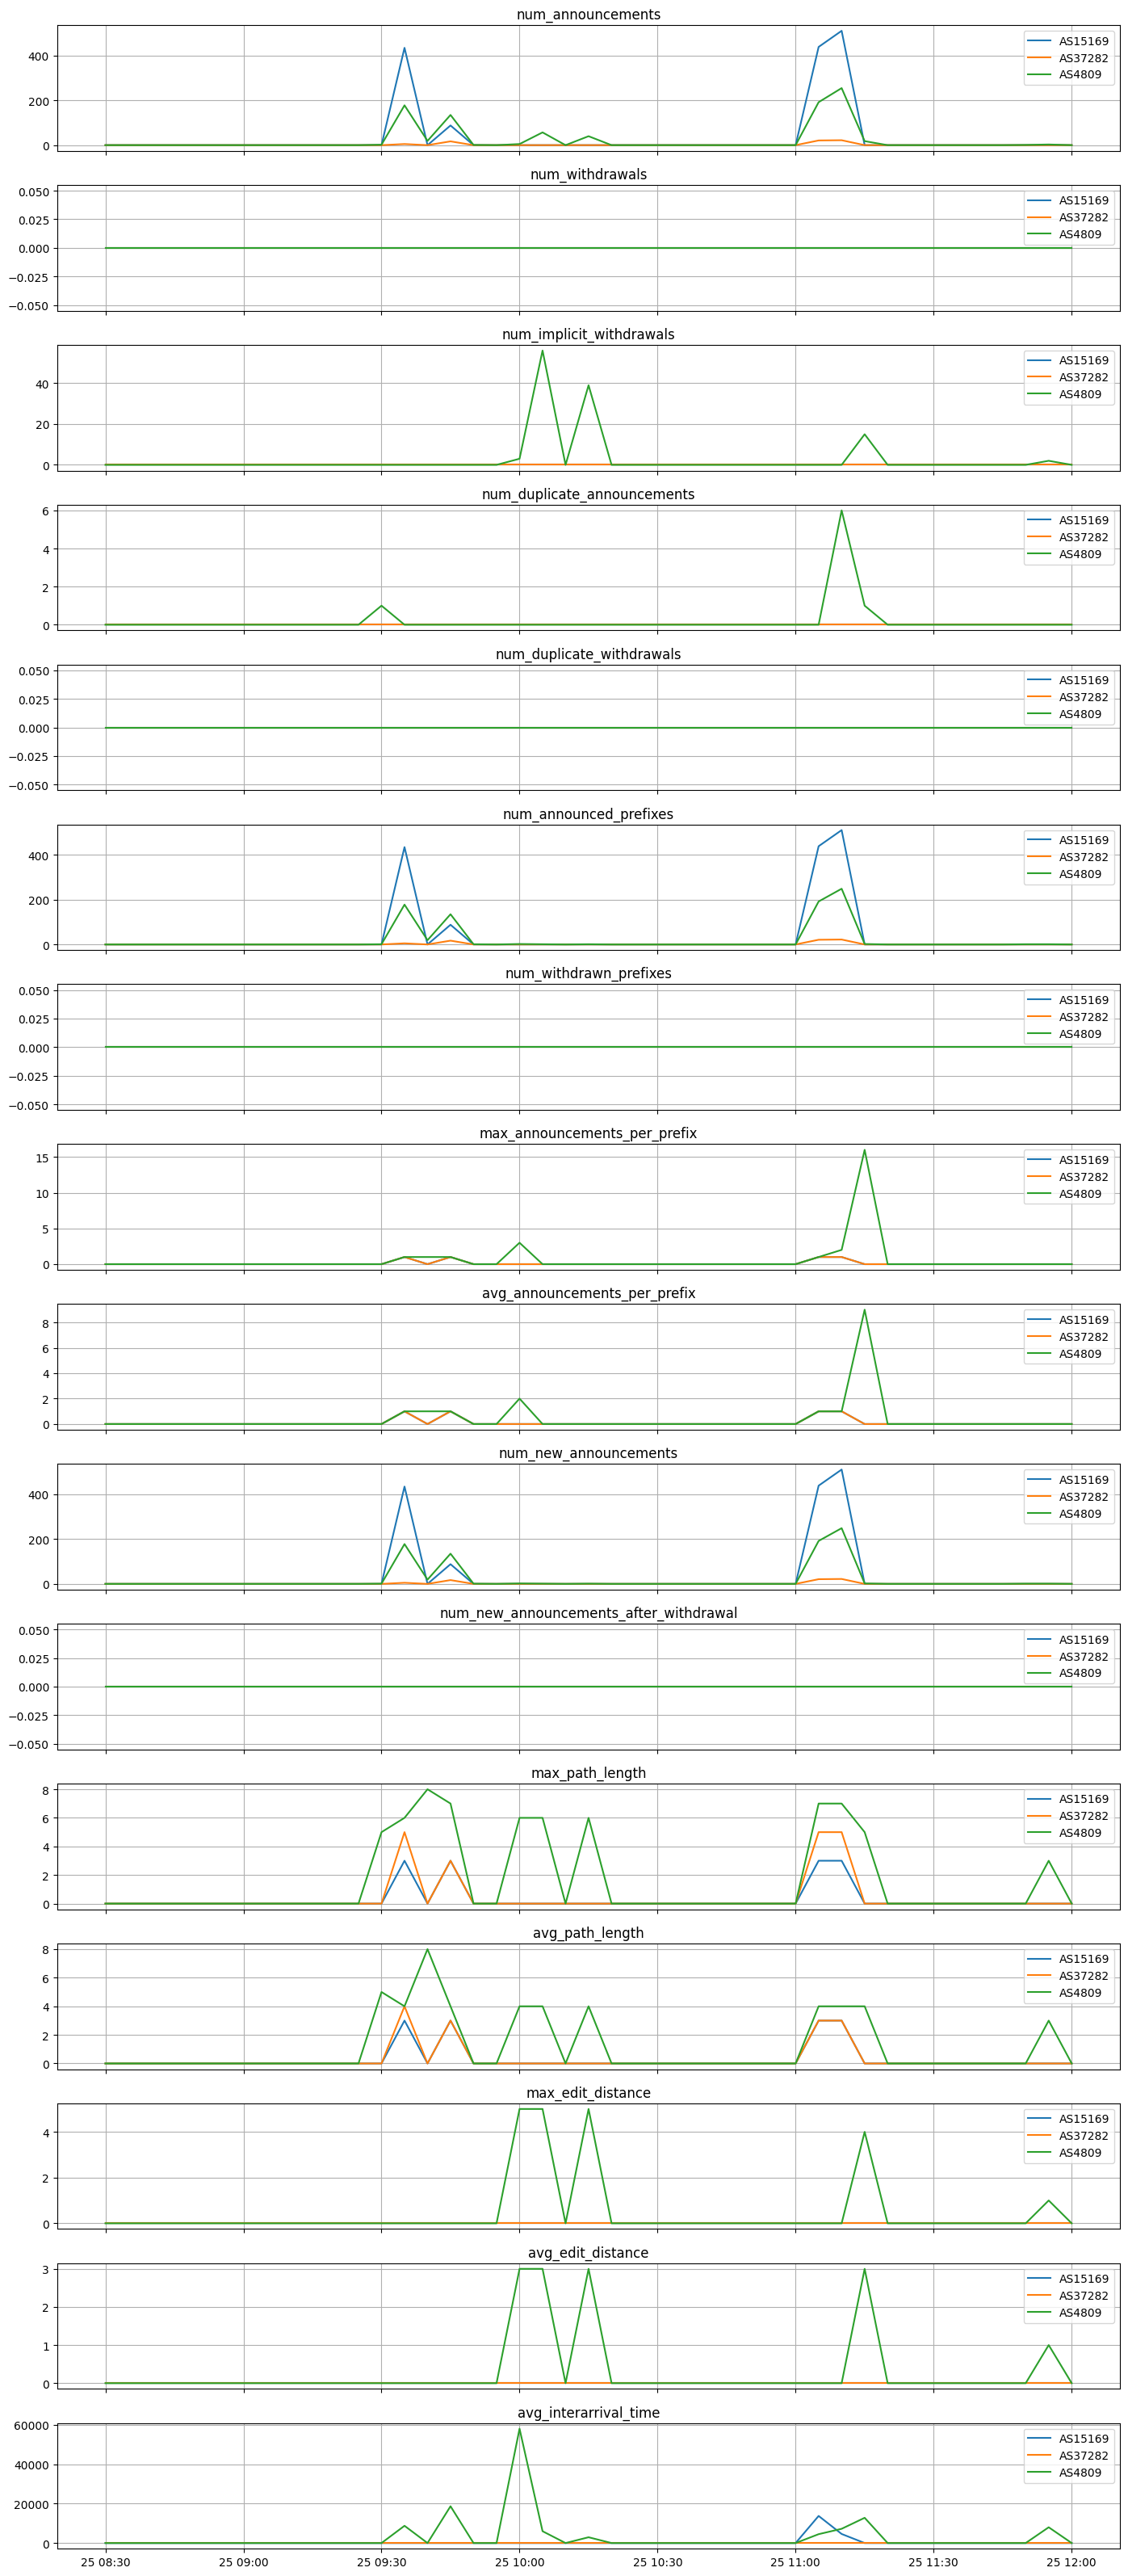

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data for each ASN
asn_15169 = pd.read_csv("bgp_features_5min_windows_AS15169.csv")
asn_37282 = pd.read_csv("bgp_features_5min_windows_AS37282.csv")
asn_4809 = pd.read_csv("bgp_features_5min_windows_AS4809.csv")

# Add a column to each DataFrame to identify the ASN
asn_15169["asn"] = "15169"
asn_37282["asn"] = "37282"
asn_4809["asn"] = "4809"

# Combine the data into a single DataFrame
combined_df = pd.concat([asn_15169, asn_37282, asn_4809], ignore_index=True)

# Convert the timestamp to a datetime object
combined_df["timestamp"] = pd.to_datetime(combined_df["timestamp"])

# Set the timestamp as the index
combined_df.set_index("timestamp", inplace=True)

# Get the list of features to plot (excluding the 'asn' column)
features_to_plot = [col for col in combined_df.columns if col != "asn"]

# Plot the relevant features over time for each ASN
fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(14, len(features_to_plot) * 2), sharex=True)
for i, feature in enumerate(features_to_plot):
    for asn in ["15169", "37282", "4809"]:
        data = combined_df[combined_df["asn"] == asn]
        axes[i].plot(data.index, data[feature], label=f"AS{asn}")
    axes[i].set_title(feature)
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## ASN feature

In [37]:
import pybgpstream
import editdistance
from datetime import datetime, timedelta
import pandas as pd

def build_routes_as(routes):
    routes_as = {}
    for prefix in routes:
        for collector in routes[prefix]:
            for peer_asn in routes[prefix][collector]:
                path = routes[prefix][collector][peer_asn]
                if len(path) == 0:
                    continue
                asn = path[-1]
                if asn not in routes_as:
                    routes_as[asn] = {}
                routes_as[asn][prefix] = path
    return routes_as

def extract_features(index, routes, old_routes_as, target_asn, temp_counts):
    features = {
        "timestamp": None,
        "asn": target_asn,
        "num_routes": 0,
        "num_new_routes": 0,
        "num_withdrawals": 0,
        "num_origin_changes": 0,
        "num_route_changes": 0,
        "max_path_length": 0,
        "avg_path_length": 0,
        "max_edit_distance": 0,
        "avg_edit_distance": 0,
        "num_announcements": temp_counts["num_announcements"],
        "num_withdrawals": temp_counts["num_withdrawals"],
        "num_unique_prefixes_announced": 0
    }

    routes_as = build_routes_as(routes)

    if index > 0:
        if target_asn in routes_as:
            num_routes = len(routes_as[target_asn])
            sum_path_length = 0
            sum_edit_distance = 0

            for prefix in routes_as[target_asn].keys():
                if target_asn in old_routes_as and prefix in old_routes_as[target_asn]:
                    path = routes_as[target_asn][prefix]
                    path_old = old_routes_as[target_asn][prefix]

                    if path != path_old:
                        features["num_route_changes"] += 1

                    if path[-1] != path_old[-1]:
                        features["num_origin_changes"] += 1

                    path_length = len(path)
                    path_old_length = len(path_old)

                    sum_path_length += path_length
                    if path_length > features["max_path_length"]:
                        features["max_path_length"] = path_length

                    edist = editdistance.eval(path, path_old)
                    sum_edit_distance += edist
                    if edist > features["max_edit_distance"]:
                        features["max_edit_distance"] = edist
                else:
                    features["num_new_routes"] += 1

            features["num_routes"] = num_routes
            features["avg_path_length"] = sum_path_length / num_routes
            features["avg_edit_distance"] = sum_edit_distance / num_routes

        if target_asn in old_routes_as:
            for prefix in old_routes_as[target_asn].keys():
                if not (target_asn in routes_as and prefix in routes_as[target_asn]):
                    features["num_withdrawals"] += 1

    # Add the number of unique prefixes announced
    features["num_unique_prefixes_announced"] = len(routes_as.get(target_asn, {}))

    return features, routes_as

# Main script execution in Jupyter notebook
stream = pybgpstream.BGPStream(
    from_time="2018-04-25 08:30:00",
    until_time="2018-04-25 12:00:00",
    record_type="updates",
    collectors=["rrc00"]
)

target_asn = "15169"
# target_asn = "37282"
# target_asn = "4809"
all_features = []
old_routes_as = {}
routes = {}
current_window_start = datetime.strptime("2018-04-25 08:30:00", "%Y-%m-%d %H:%M:%S")
index = 0

# Initialize temporary counts for announcements and withdrawals
temp_counts = {
    "num_announcements": 0,
    "num_withdrawals": 0
}

for rec in stream.records():
    for elem in rec:
        update = elem.fields
        elem_time = datetime.utcfromtimestamp(elem.time)
        
        if elem_time >= current_window_start + timedelta(minutes=5):
            features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
            features['timestamp'] = current_window_start
            all_features.append(features)

            # Reset for the new window
            current_window_start += timedelta(minutes=5)
            routes = {}
            index += 1
            temp_counts = {
                "num_announcements": 0,
                "num_withdrawals": 0
            }

        prefix = update.get("prefix")
        if prefix is None:
            continue

        peer_asn = update.get("peer_asn", "unknown")
        collector = rec.collector

        if prefix not in routes:
            routes[prefix] = {}
        if collector not in routes[prefix]:
            routes[prefix][collector] = {}

        if elem.type == 'A':
            path = update['as-path'].split()
            if path[-1] == target_asn:
                routes[prefix][collector][peer_asn] = path
                temp_counts["num_announcements"] += 1
        elif elem.type == 'W':
            if prefix in routes and collector in routes[prefix]:
                if peer_asn in routes[prefix][collector]:
                    if routes[prefix][collector][peer_asn][-1] == target_asn:
                        routes[prefix][collector].pop(peer_asn, None)
                        temp_counts["num_withdrawals"] += 1

# Final aggregation for the last window
features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
features['timestamp'] = current_window_start
all_features.append(features)

df_features = pd.json_normalize(all_features, sep='_').fillna(0)
df_features.to_csv(f'bgp_features_asn_{target_asn}.csv', index=False)
print(df_features)

In [34]:
# target_asn = "15169"
# target_asn = "37282"
# target_asn = "4809"
# df_features = pd.read_csv('/home/hb/BGP_data_analysis/pybgpstream/bgp_features_asn_15169.csv')

In [ ]:
# Calculate the difference between consecutive rows
df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns
diff = df_features[numeric_cols].diff().abs()

# Define the threshold for each column as mean + 1.5 * std
thresholds = diff.mean() + 2 * diff.std()

# Find rows where the difference exceeds the threshold
anomalies = (diff > thresholds).any(axis=1)

# Initialize the anomaly_status column with "no anomalies detected"
df_features['anomaly_status'] = "no anomalies detected"

# Label anomalies and add reasons
for idx in df_features[anomalies].index:
    reasons = []
    for col in numeric_cols:
        if diff.loc[idx, col] > thresholds[col]:
            reasons.append(f"{col}={df_features.loc[idx, col]}")
    if reasons:
        df_features.at[idx, 'anomaly_status'] = f"anomaly due to high value of {', '.join(reasons)}"

# Display the DataFrame to verify
print(df_features)

# Save the updated DataFrame with anomalies
df_features.to_csv(f'bgp_features_asn_{target_asn}_with_anomalies.csv', index=False)

             timestamp    asn  num_routes  num_new_routes  num_withdrawals  \
0  2018-04-25 08:30:00  15169           0               0                0   
1  2018-04-25 08:35:00  15169           0               0                0   
2  2018-04-25 08:40:00  15169           0               0                0   
3  2018-04-25 08:45:00  15169           0               0                0   
4  2018-04-25 08:50:00  15169           0               0                0   
5  2018-04-25 08:55:00  15169           0               0                0   
6  2018-04-25 09:00:00  15169           0               0                0   
7  2018-04-25 09:05:00  15169           0               0                0   
8  2018-04-25 09:10:00  15169           0               0                0   
9  2018-04-25 09:15:00  15169           0               0                0   
10 2018-04-25 09:20:00  15169           0               0                0   
11 2018-04-25 09:25:00  15169           0               0       

/tmp/ipykernel_169611/1993025700.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20', num_colors)


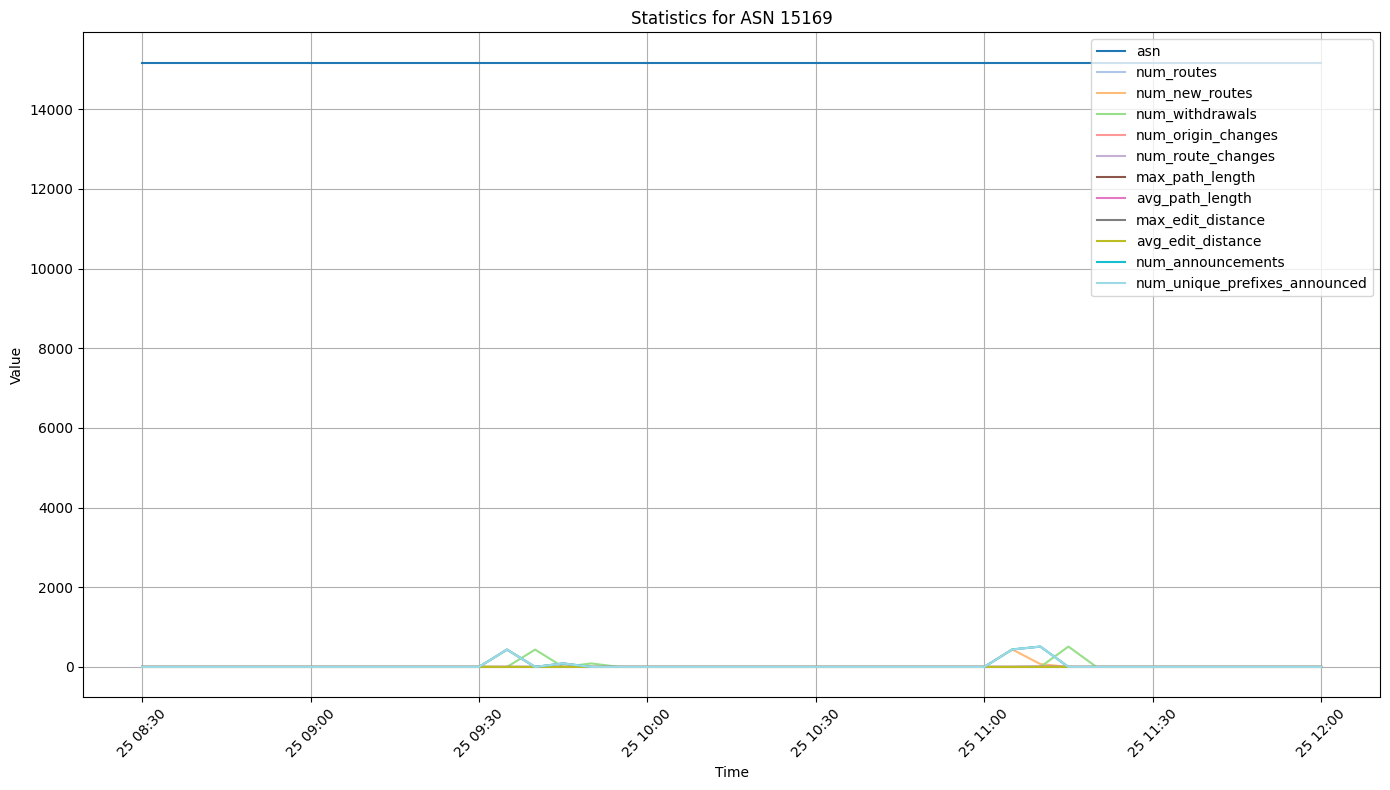

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the color map
num_colors = len(numeric_cols)
color_map = cm.get_cmap('tab20', num_colors)

# Plotting the statistics
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols):
    plt.plot(df_features['timestamp'], df_features[col], label=col, color=color_map(i))

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Statistics for ASN {target_asn}')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# April 2018: 1300 IP addresses within Amazon Web Services space were hijacked by eNet